In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/rock_you_clean_v2.parquet/


part-00000-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00001-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00002-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00003-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00004-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00005-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00006-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00007-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00008-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00009-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00010-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00011-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00012-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00013-020704b6-9474-47ac-94e6-dbf9bc351e31-c000.snappy.parquet
part-00014-020704b6-9474-47ac-94e6-dbf9bc351e31-

In [63]:
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()


spark = SparkSession.builder \
    .appName("SparkRAPIDS") \
    .master("local[*]") \
    .config("spark.plugins", "com.nvidia.spark.SQLPlugin") \
    .config("spark.rapids.sql.enabled", "true") \
    .config("spark.rapids.sql.concurrentGpuTasks", "1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.executor.resource.gpu.amount", "1") \
    .config("spark.task.resource.gpu.amount", "1") \
    .getOrCreate()


In [64]:
# Get the number of GPUs
num_gpus = spark.sparkContext.resources.get('gpu', {}).get('addresses', '').count(',') + 1

print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


In [65]:
df=spark.read.parquet("/content/drive/MyDrive/rock_you_clean_v2.parquet/")

In [66]:
df.show(2,truncate=False)

+------------+----------------------------------------+------+-----------------------------------+-----------------------------------+-----+
|password    |sha1                                    |prefix|suffix                             |HASH                               |COUNT|
+------------+----------------------------------------+------+-----------------------------------+-----------------------------------+-----+
|oreoismybab3|EB53000003220623CFABD473187026A71184A479|EB530 |00003220623CFABD473187026A71184A479|00003220623CFABD473187026A71184A479|6    |
|jkloiu      |9C5B8000097B0C78E24DAE2FCC10FF1BE4B6F209|9C5B8 |000097B0C78E24DAE2FCC10FF1BE4B6F209|000097B0C78E24DAE2FCC10FF1BE4B6F209|616  |
+------------+----------------------------------------+------+-----------------------------------+-----------------------------------+-----+
only showing top 2 rows



In [67]:
feature_dff = df.withColumn("is_lower",F.col("password").rlike("^[a-z]+$")) \
        .withColumn("is_upper",F.col("password").rlike("^[A-Z]+$")) \
        .withColumn("is_digit",F.col("password").rlike("^[0-9]+$")) \
        .withColumn("has_letter_and_digit", F.col("password").rlike(r"(?=.*[a-zA-Z])(?=.*\d)"))\
        .withColumn("has_digits", F.col("password").rlike(".*[0-9].*"))\
        .withColumn("has_upper",F.col("password").rlike(".*[A-Z].*")) \
        .withColumn("has_lower",F.col("password").rlike(".*[a-z].*")) \
        .withColumn("has_symbols",F.col("password").rlike("[^a-zA-Z0-9].*")) \
        .withColumn("has_spaces",F.col("password").rlike("\s")) \
        .withColumn("has_special_characters", F.col("password").rlike(r"[!@#$%^&*()_+{}\|:<>?~`\-=\[\];',./]"))\
        .withColumn("length",F.length(F.col("password")))\
        .withColumn("common_or_rare",F.when(F.col("COUNT")>=10,"common").otherwise("rare"))


In [68]:
def turning_to_int(classified_df):
    # Convert boolean to int
    cols_to_convert = [
        "is_lower", "is_upper", "is_digit", "has_digits","has_upper", "has_lower",
        "has_symbols", "has_spaces", "has_special_characters", "has_letter_and_digit"
    ]
    for c in cols_to_convert:
        classified_df = classified_df.withColumn(c, F.col(c).cast("int"))
    return classified_df

In [69]:
df=turning_to_int(feature_dff)
df.show(2,truncate=False)

+------------+----------------------------------------+------+-----------------------------------+-----------------------------------+-----+--------+--------+--------+--------------------+----------+---------+---------+-----------+----------+----------------------+------+--------------+
|password    |sha1                                    |prefix|suffix                             |HASH                               |COUNT|is_lower|is_upper|is_digit|has_letter_and_digit|has_digits|has_upper|has_lower|has_symbols|has_spaces|has_special_characters|length|common_or_rare|
+------------+----------------------------------------+------+-----------------------------------+-----------------------------------+-----+--------+--------+--------+--------------------+----------+---------+---------+-----------+----------+----------------------+------+--------------+
|oreoismybab3|EB53000003220623CFABD473187026A71184A479|EB530 |00003220623CFABD473187026A71184A479|00003220623CFABD473187026A71184A479|6 

In [70]:
df =df.withColumn("score", F.col("has_upper")+F.col("has_lower")+F.col("has_digits")+ F.col("has_special_characters")+ F.when(F.col("length")>8,1).otherwise(0))

df = df.withColumn("password_strength",F.when(F.col("score")==5 ,"Strong").when(F.col("score")>=3,"medium").otherwise("weak"))

In [71]:
import pyspark.sql.functions as F

In [72]:
def spliting_data(df):
    #spliting data manualy because classes are imbalance
    full_df=df.withColumn("row_id",F.monotonically_increasing_id())

    weak_df=full_df.filter(F.col("password_strength")=="weak")
    medium_df=full_df.filter(F.col("password_strength")=="medium")
    strong_df=full_df.filter(F.col("password_strength")=="Strong")

    sample_count=15000

    weak_train=weak_df.sample(False,float(sample_count)/weak_df.count(),seed=42)
    #false means we don't take same entry again and structure(withreplacement, fraction ,seed)
    medium_train=medium_df.sample(False,float(sample_count)/medium_df.count(),seed=42)
    strong_train=strong_df.sample(False,float(sample_count)/strong_df.count(),seed=42)

    train_df = weak_train.union(medium_train).union(strong_train)
    test_df=full_df.join(train_df.select("row_id"),on="row_id",how="left_anti")

    return train_df,test_df

In [73]:
train_df,test_df=spliting_data(df)

In [74]:
from pyspark.ml.feature import VectorAssembler,StringIndexer,IndexToString,StringIndexerModel

In [75]:
def turning_string_to_index(df,label_col="password_strength",feature_col="common_or_rare"):

    #transform label to index
    index_l=StringIndexer(inputCol=label_col, outputCol="label")
    index_l_model=index_l.fit(df)
    df=index_l_model.transform(df)

    #trandform our common_or_rare
    index_f=StringIndexer(inputCol=feature_col,outputCol="common_or_rare_index")
    index_f_model=index_f.fit(df)
    df=index_f_model.transform(df)

    return df,index_l_model,index_f_model

In [76]:
df,index_l_model,index_f_model=turning_string_to_index(df,label_col="password_strength",feature_col="common_or_rare")

In [77]:
train_df=index_l_model.transform(train_df)
test_df=index_l_model.transform(test_df)
train_df=index_f_model.transform(train_df)
test_df=index_f_model.transform(test_df)

In [78]:
feature_columns = [
"is_lower", "is_upper", "is_digit", "has_digits", "has_upper", "has_lower",
"has_symbols", "has_spaces", "has_special_characters", "length", "common_or_rare_index"]

In [79]:
def assemble_features(df,feature_columns):
    # Vector assembler
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    final_df = assembler.transform(df)
    final_df.groupBy("password_strength").count().show()
    return final_df

In [80]:
train_df=assemble_features(train_df,feature_columns)
test_df=assemble_features(test_df,feature_columns)

+-----------------+-----+
|password_strength|count|
+-----------------+-----+
|             weak|14978|
|           medium|15046|
|           Strong|15153|
+-----------------+-----+

+-----------------+--------+
|password_strength|   count|
+-----------------+--------+
|             weak|10130473|
|           medium| 4090786|
|           Strong|   17761|
+-----------------+--------+



In [81]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

params = {
    "tree_method": "gpu_hist",      # Enable GPU training
    "n_estimators": 10,
    "max_depth": 6,
    "grow_policy": "depthwise",
    "num_workers": 1,
    'features_col': "features",
    'label_col': "label"
}

classifier = SparkXGBClassifier(**params)


In [82]:
from time import time
import numpy as np
def with_benchmark(phrase, action):
  a_l=[]
  for i in range(3):
    start = time()
    result = action()
    end = time()
    a_l.append(round(end - start, 2))
    #print('{} took {} seconds'.format(phrase, round(end - start, 2)))
    a_l=np.array(a_l)
    print(f"average_time:{np.mean(a_l)}")
    return result
model = with_benchmark('Training', lambda: classifier.fit(train_df))

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'grow_policy': 'depthwise', 'max_depth': 6, 'tree_method': 'gpu_hist', 'num_class': 3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 10}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


average_time:571.64


In [83]:
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel

In [84]:
!nvidia-smi


Mon Jun  2 01:55:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     290MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [85]:
model.write().overwrite().save( '/content/model_agaricus')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:55:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [86]:
loaded_model = SparkXGBClassifierModel().load('/content/model_agaricus')

In [87]:
result = loaded_model.transform(test_df).cache()

In [88]:
av_ac=[]
for i in range(0,3,1):
  accuracy = with_benchmark(
      'Evaluation',
      lambda: MulticlassClassificationEvaluator().setLabelCol('label').evaluate(result))
  av_ac.append(accuracy)
  print(f"average_accuracy:{np.mean(np.array(av_ac))}")
print('Accuracy is ' + str(accuracy))

average_time:835.62
average_accuracy:0.9997732342361576
average_time:31.48
average_accuracy:0.9997732342361576
average_time:31.11
average_accuracy:0.9997732342361575
Accuracy is 0.9997732342361576


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

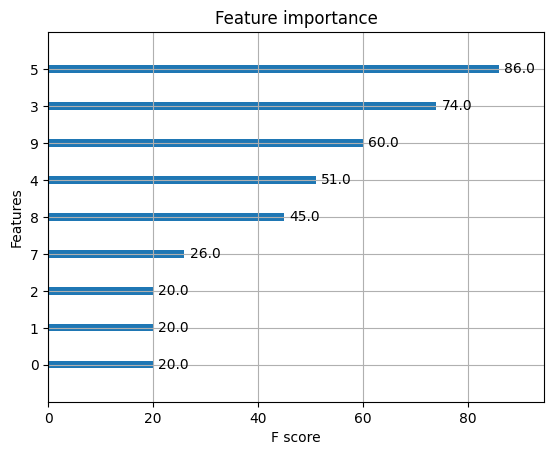

In [89]:
import xgboost as xgb
# convert SparkXGBClassifier to xgboost booster
booster: xgb.Booster = loaded_model.get_booster()
# use xgboost plotting functions to plot feature importance
xgb.plot_importance(booster)

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
pred=IndexToString(inputCol="prediction",outputCol="predicted_Label",labels=index_l_model.labels)

In [93]:
predictions=pred.transform(result)

In [94]:
pred_1=IndexToString(inputCol="label",outputCol="true_Label",labels=index_l_model.labels)

In [95]:
predictions=pred_1.transform(predictions)

In [96]:
pred_c=IndexToString(inputCol="common_or_rare_index",outputCol="common_or_rare_string",labels=index_f_model.labels)

In [97]:
predictions=pred_c.transform(predictions)

In [98]:

def creating_cm(predictions,index_l_model):
    predictions_p=predictions.select("predicted_Label","true_Label","password").toPandas()
    cm=confusion_matrix(predictions_p["true_Label"],predictions_p["predicted_Label"],labels=index_l_model.labels)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=index_l_model.labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


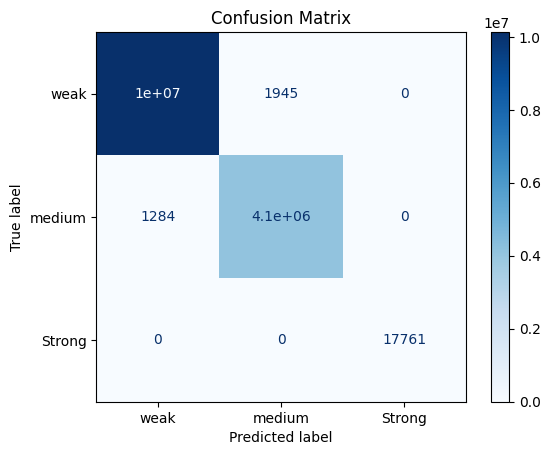

In [99]:
creating_cm(predictions,index_l_model)

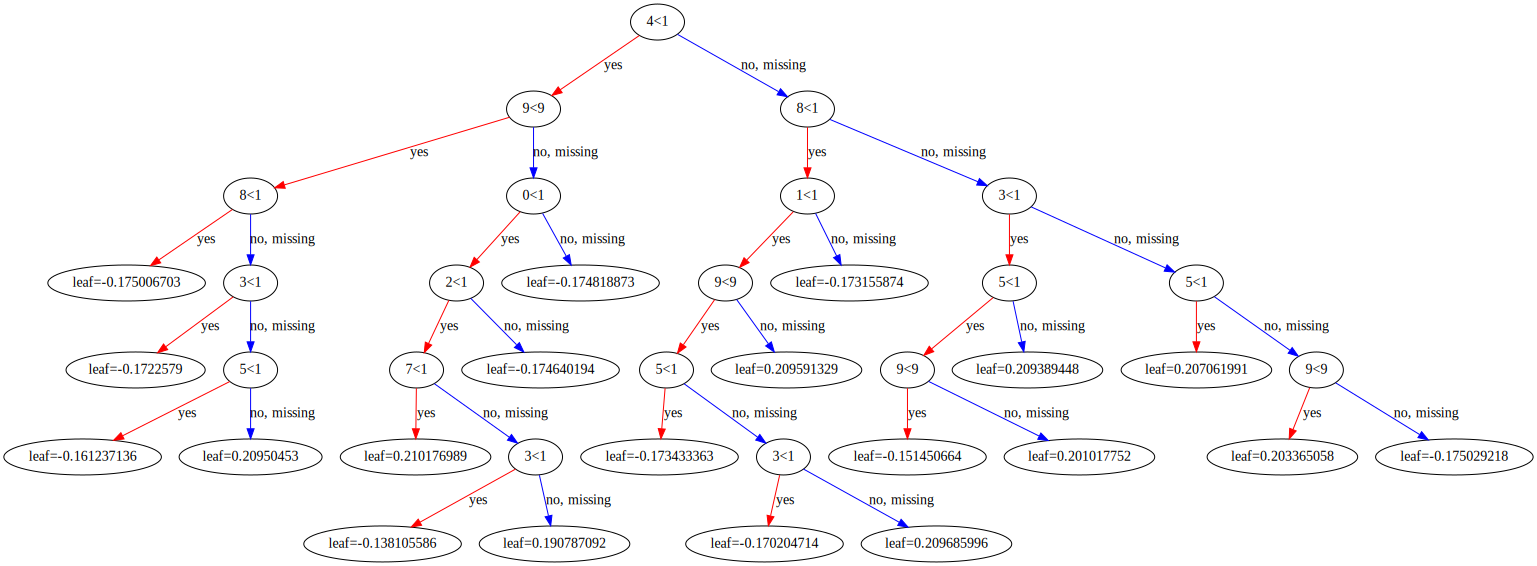

In [100]:
xgb.to_graphviz(booster, num_trees=10)